# Classification Models for Predicting San Francisco Crime Classifications

In [13]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss

## Load Data

In [15]:
# Load train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["Id"]

## Stratified Sampling
- Pre-filter Rare Classes. Drop categories that appear fewer than 20 times.
- Encode Category. Encode categorical labels to numeric values for model compatibility.
- Stratified 10% Sampling. Sample 10% of the training data with class proportions preserved

In [16]:
# Drop categories that appear fewer than 20 times to allow for reliable stratified sampling
min_class_count = 20
valid_categories = train["Category"].value_counts()[lambda x: x >= min_class_count].index
train = train[train["Category"].isin(valid_categories)].copy()

# Encode categorical labels to numeric values for model compatibility
label_encoder = LabelEncoder()
train["EncodedCategory"] = label_encoder.fit_transform(train["Category"])
class_names = label_encoder.classes_

# Sample 10% of the training data with class proportions preserved
train_sampled, _ = train_test_split(
    train, test_size=0.9, stratify=train["EncodedCategory"], random_state=42
)
train_sampled = train_sampled.reset_index(drop=True)

## Feature Engineering
- Extract time-based and geographic features from the dataset

In [17]:
def extract_features(df):
    df = df.copy()
    df["Dates"] = pd.to_datetime(df["Dates"])
    df["Hour"] = df["Dates"].dt.hour
    df["Month"] = df["Dates"].dt.month
    df["Year"] = df["Dates"].dt.year
    return df[["DayOfWeek", "PdDistrict", "Hour", "Month", "Year", "X", "Y"]]

X = extract_features(train_sampled)
y = train_sampled["Category"]
y_encoded = train_sampled["EncodedCategory"]
X_test = extract_features(test)

## Visualizations
- Explore the distribution of categories and temporal patterns

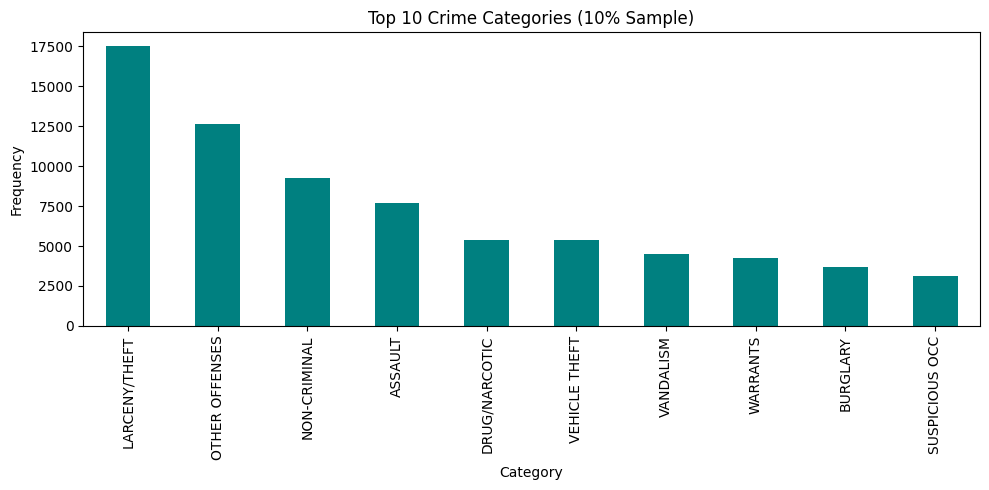

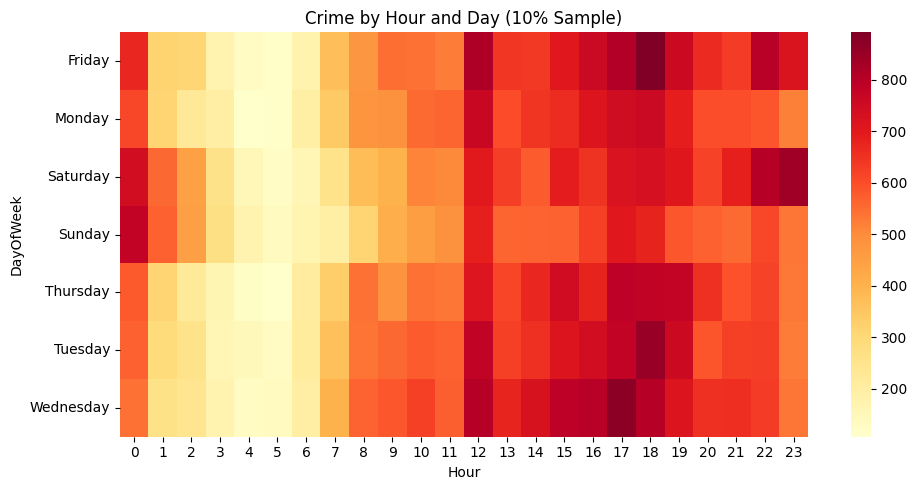

In [18]:
# ------------------ Visualizations ------------------ 
# Explore the distribution of categories and temporal patterns
train_sampled["Dates"] = pd.to_datetime(train_sampled["Dates"])
train_sampled["Hour"] = train_sampled["Dates"].dt.hour

plt.figure(figsize=(10, 5))
train_sampled["Category"].value_counts().head(10).plot(kind="bar", color="teal")
plt.title("Top 10 Crime Categories (10% Sample)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(train_sampled.pivot_table(index="DayOfWeek", columns="Hour", values="Category", aggfunc="count"), cmap="YlOrRd")
plt.title("Crime by Hour and Day (10% Sample)")
plt.tight_layout()
plt.show()

## Preprocessing + PCA
- Apply one-hot encoding, standardization, and reduce feature dimensionality using PCA 
- Professor suggested to help speed up training time while maintaining accuracy (Dr. Nabeel, National University)

In [19]:
cat_features = ["DayOfWeek", "PdDistrict"]
num_features = ["Hour", "Month", "Year", "X", "Y"]

# Initial preprocessor before PCA
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", StandardScaler(), num_features)
])

# PCA to reduce to 10 components while maintaining substantial explained variance
dim_reduction = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=10))
])

## Define Models
- Initialize classifiers including a fast linear kernel for SVC

In [20]:
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=15, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier": SVC(probability=True, kernel="linear", C=1.0)
}

## Ensure Valid Stratification 
- All classes in the training/validation split must appear at least twice

In [21]:
valid_classes = y_encoded.value_counts()[lambda x: x >= 2].index
mask = y_encoded.isin(valid_classes)
X_filtered = X[mask]
y_filtered = y_encoded[mask]

## Split for Training and Validation

In [22]:
# ------------------ Split for Training and Validation ------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

results = []

## Train, Evaluate, Predict 

In [23]:
full_class_list = ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT',         'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING',     'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY',            'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',        'WARRANTS', 'WEAPON LAWS']
for name, model in models.items():
    print(f"Training {name}...")
    pipe = Pipeline([
        ("features", dim_reduction),
        ("classifier", model)
    ])
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict_proba(X_val)
    y_val_pred = np.clip(y_val_pred, 1e-15, 1 - 1e-15)
    loss = log_loss(y_val, y_val_pred, labels=np.arange(len(class_names)))
    results.append((name, loss))

    y_test_pred = pipe.predict_proba(X_test)
    y_test_pred = np.clip(y_test_pred, 1e-15, 1 - 1e-15)

    df_sub = pd.DataFrame(y_test_pred, columns=label_encoder.inverse_transform(np.               arange(len(class_names))))
    df_sub.insert(0, "Id", test_ids)

    for col in full_class_list:
        if col not in df_sub.columns:
            df_sub[col] = 0.0
    df_sub = df_sub[["Id"] + full_class_list]
    fname = f"submission_{name.lower().replace('classifier', '')}.csv"
    df_sub.to_csv(fname, index=False)
    print(f"Saved {fname}")

Training DecisionTreeClassifier...
Saved submission_decisiontree.csv
Training RandomForestClassifier...
Saved submission_randomforest.csv
Training SupportVectorClassifier...
Saved submission_supportvector.csv


# Plot Results 

                     Model    LogLoss
0   DecisionTreeClassifier  11.790296
1   RandomForestClassifier   5.478222
2  SupportVectorClassifier   2.668147


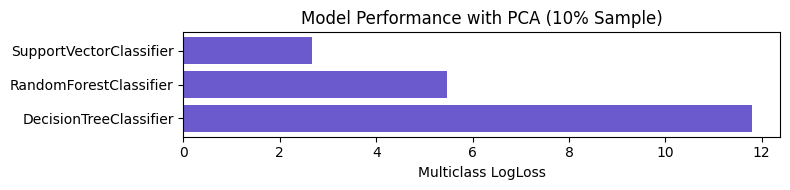

In [24]:
df_results = pd.DataFrame(results, columns=["Model", "LogLoss"])
print(df_results)

plt.figure(figsize=(8, 2))
plt.barh(df_results["Model"], df_results["LogLoss"], color="slateblue")
plt.xlabel("Multiclass LogLoss")
plt.title("Model Performance with PCA (10% Sample)")
plt.tight_layout()
plt.show() 

## Conclusion 
- This study reduced San Francisco Crime Classification dataset to 10% for model training efficiency.
- It applied feature extraction and PCA to reduce dimensionality from ~28 features to 10 principal components.
- Three models were trained: DecisionTree, RandomForest, and SupportVectorClassifier with linear kernel for speed.
- PCA retained most of the explained variance while reducing complexity, which benefits models like SVC.
- Log-loss was used to evaluate performance, with results visualized for comparison.
- This pipeline showcases how to preprocess, reduce dimensionality, and efficiently train multi-class classifiers even on large, high-cardinality categorical datasets.